**Date**: 2018-07-24

**Authors**: Yichen Fang

**Purpose**: See if the trained model indeed produces random results on randomly generated sequences as a negative control

This notebook tests a naive alignment scheme that selects the first 1000 positions of a DNA sequence (add null positions to the end if a sequence is shorter than 1000). The sequences are shuffled before feeding into the neural network. The training data consist of 8712 sequences, and the validation data consist of 968 sequences. The test data consist of 1072 sequences.

The random test data consist of 2000 randomly generated sequences, each with a length of 1000 positions. Each random sequence is generated by randomly selecting a letter from `A, C, G, T` for each position; it is also randomly assigned a classification sign of either `0` or `1`. The motif is calculated based on the randomly generated sequences.

**Background**:
- Since now we are quite confident that our model would produce decent accuracy results, we need to make sure it does not produce decent results on randomly generated sequences.

**Experiment**:

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

Load the `pickle` buffered list:

In [3]:
with open("../data/list_buffer.txt", "rb") as buff:
    seq_record_list = pickle.load(buff)
len(seq_record_list)

10752

Since we only have calculated one motif `bcd` for the randomly generated sequences, we need to strip away the other two motifs from the real sequences:

In [4]:
counter = 0
for sequence in seq_record_list:
    old_encoding = sequence[3]
    new_encoding = []
    for entry in old_encoding:
        new_encoding.append(entry[:4] + [entry[6]])
    sequence[3] = new_encoding
    counter += 1
    if counter % 1000 == 1:
        print("finished: " + str(counter))

finished: 1
finished: 1001
finished: 2001
finished: 3001
finished: 4001
finished: 5001
finished: 6001
finished: 7001
finished: 8001
finished: 9001
finished: 10001


The following cell randomly shuffles the sequences.

In [6]:
from random import shuffle
shuffle(seq_record_list)

The following cell transforms the data into a format that is recognizable by the neural network model.

In [7]:
# A helper function to flatten a 2d list to 1d.
# Input: [[1, 2], [2, 3], [3, 4, 5]]
# Output: [1, 2, 2, 3, 3, 4, 5]
def flatten(lst):
    new_lst = []
    for sub_lst in lst:
        for item in sub_lst:
            new_lst.append(item)
    return new_lst

# A helper function to transform a lst so that its length becomes read_len by:
# 1. If len(lst) > read_len, curtail the end of the lst.
# 2. If len(lst) < read_len, keep extending the end of the lst with 0 (NA).
def curtail(lst, read_len):
    if len(lst) > read_len:
        lst = lst[:read_len]
    else:
        for i in range(read_len - len(lst)):
            lst.append([0, 0, 0, 0, 0])
    return lst

# Produce the train-test split
# length_read: the length that you want all DNA sequences to conform to
def prepare_input(training_size, test_size, length_read, original_list):
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    seq_count = 0
    while seq_count < training_size:
        X_train.append(flatten(curtail(original_list[seq_count][3], length_read)))
        y_train.append(int(original_list[seq_count][1]))
        seq_count += 1
    while seq_count < (training_size + test_size):
        X_test.append(flatten(curtail(original_list[seq_count][3], length_read)))
        y_test.append(int(original_list[seq_count][1]))
        seq_count += 1
    return X_train, y_train, X_test, y_test

# Turn list into numpy tensors that can directly feed into a neural network model
def to_np_array(X_train, y_train, X_test, y_test):
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    if len(y_train.shape) == 1:
        y_train = np.transpose(np.array([y_train]))
    X_test = np.array(X_test)
    y_test = np.transpose(np.array(y_test))
    if len(y_test.shape) == 1:
        y_test = np.transpose(np.array([y_test]))
    return X_train, y_train, X_test, y_test

In [8]:
X_train, y_train, X_test, y_test = prepare_input(9680, 1072, 1000, seq_record_list)
X_train, y_train, X_test, y_test = to_np_array(X_train, y_train, X_test, y_test)
[X_train.shape, y_train.shape, X_test.shape, y_test.shape]

[(9680, 5000), (9680, 1), (1072, 5000), (1072, 1)]

We run the experiment with four LSTM layers, having 8, 8, 4, 4 units respectively, and 250 epoches:

In [10]:
from keras.models import Model, Sequential
from keras.layers import Dense, CuDNNLSTM

In [11]:
X_train_rnn = X_train.reshape(9680, 1000, 5)

In [12]:
model = Sequential()
model.add(CuDNNLSTM(8, input_shape=(1000, 5), return_sequences=True))
model.add(CuDNNLSTM(8, return_sequences=True))
model.add(CuDNNLSTM(4, return_sequences=True))
model.add(CuDNNLSTM(4))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train_rnn, y_train, epochs=250, batch_size=128, validation_split=0.1)

Train on 8712 samples, validate on 968 samples
Epoch 1/250
8712/8712 [==============================] - 136s 16ms/step - loss: 0.6715 - acc: 0.5931 - val_loss: 0.6623 - val_acc: 0.5795
Epoch 2/250
8712/8712 [==============================] - 25s 3ms/step - loss: 0.6556 - acc: 0.5958 - val_loss: 0.6568 - val_acc: 0.6033
Epoch 3/250
8712/8712 [==============================] - 24s 3ms/step - loss: 0.6527 - acc: 0.6037 - val_loss: 0.6566 - val_acc: 0.6043
Epoch 4/250
8712/8712 [==============================] - 23s 3ms/step - loss: 0.6521 - acc: 0.6041 - val_loss: 0.6539 - val_acc: 0.6002
Epoch 5/250
8712/8712 [==============================] - 23s 3ms/step - loss: 0.6502 - acc: 0.6057 - val_loss: 0.6548 - val_acc: 0.6002
Epoch 6/250
8712/8712 [==============================] - 23s 3ms/step - loss: 0.6493 - acc: 0.6062 - val_loss: 0.6491 - val_acc: 0.6105
Epoch 7/250
8712/8712 [==============================] - 23s 3ms/step - loss: 0.6473 - acc: 0.6063 - val_loss: 0.6524 - val_acc: 0.6126

Epoch 120/250
8712/8712 [==============================] - 23s 3ms/step - loss: 0.3628 - acc: 0.8587 - val_loss: 0.2752 - val_acc: 0.8926
Epoch 121/250
8712/8712 [==============================] - 23s 3ms/step - loss: 0.2520 - acc: 0.9070 - val_loss: 0.3088 - val_acc: 0.8884
Epoch 122/250
8712/8712 [==============================] - 23s 3ms/step - loss: 0.2672 - acc: 0.9037 - val_loss: 0.2668 - val_acc: 0.9039
Epoch 123/250
8712/8712 [==============================] - 23s 3ms/step - loss: 0.2510 - acc: 0.9107 - val_loss: 0.4042 - val_acc: 0.8151
Epoch 124/250
8712/8712 [==============================] - 24s 3ms/step - loss: 0.2542 - acc: 0.9065 - val_loss: 0.3366 - val_acc: 0.8688
Epoch 125/250
8712/8712 [==============================] - 23s 3ms/step - loss: 0.2467 - acc: 0.9115 - val_loss: 0.3619 - val_acc: 0.8399
Epoch 126/250
8712/8712 [==============================] - 23s 3ms/step - loss: 0.2747 - acc: 0.8997 - val_loss: 0.5435 - val_acc: 0.7882
Epoch 127/250
8712/8712 [=========

8712/8712 [==============================] - 23s 3ms/step - loss: 0.1739 - acc: 0.9470 - val_loss: 0.2858 - val_acc: 0.9081
Epoch 239/250
8712/8712 [==============================] - 23s 3ms/step - loss: 0.1635 - acc: 0.9516 - val_loss: 0.1883 - val_acc: 0.9349
Epoch 240/250
8712/8712 [==============================] - 23s 3ms/step - loss: 0.1498 - acc: 0.9560 - val_loss: 0.1979 - val_acc: 0.9360
Epoch 241/250
8712/8712 [==============================] - 23s 3ms/step - loss: 0.1648 - acc: 0.9498 - val_loss: 0.1358 - val_acc: 0.9669
Epoch 242/250
8712/8712 [==============================] - 23s 3ms/step - loss: 0.1530 - acc: 0.9543 - val_loss: 0.1357 - val_acc: 0.9659
Epoch 243/250
8712/8712 [==============================] - 23s 3ms/step - loss: 0.1502 - acc: 0.9553 - val_loss: 0.1811 - val_acc: 0.9349
Epoch 244/250
8712/8712 [==============================] - 23s 3ms/step - loss: 0.1334 - acc: 0.9633 - val_loss: 0.1490 - val_acc: 0.9618
Epoch 245/250
8712/8712 [=======================

**Result**:

The following cell **visualize** the training/validation accuracies and losses over each epoch.

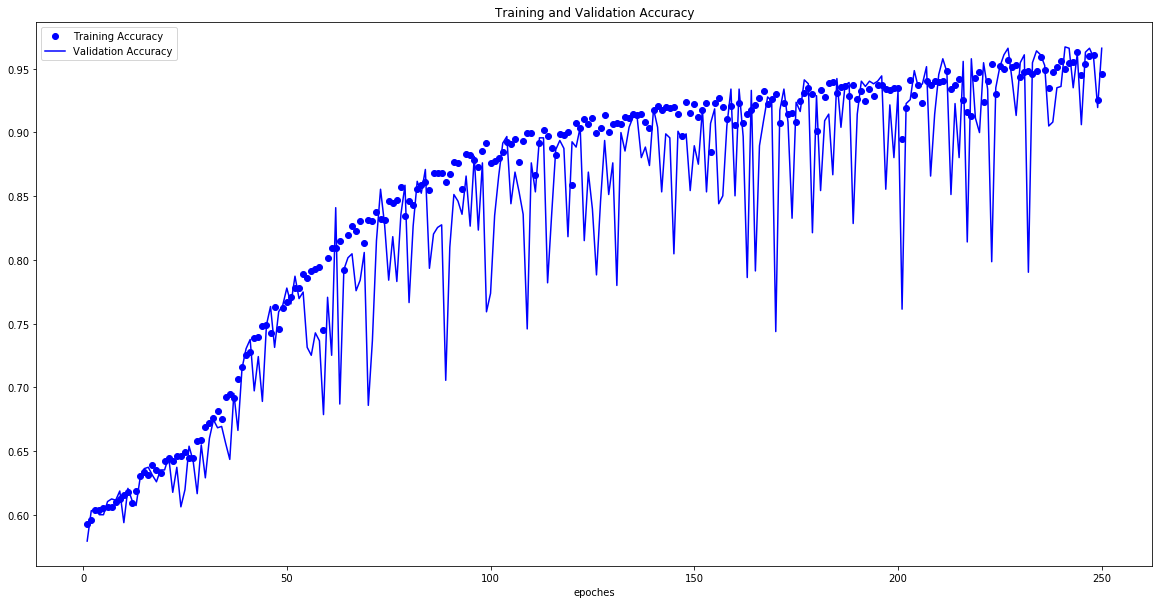

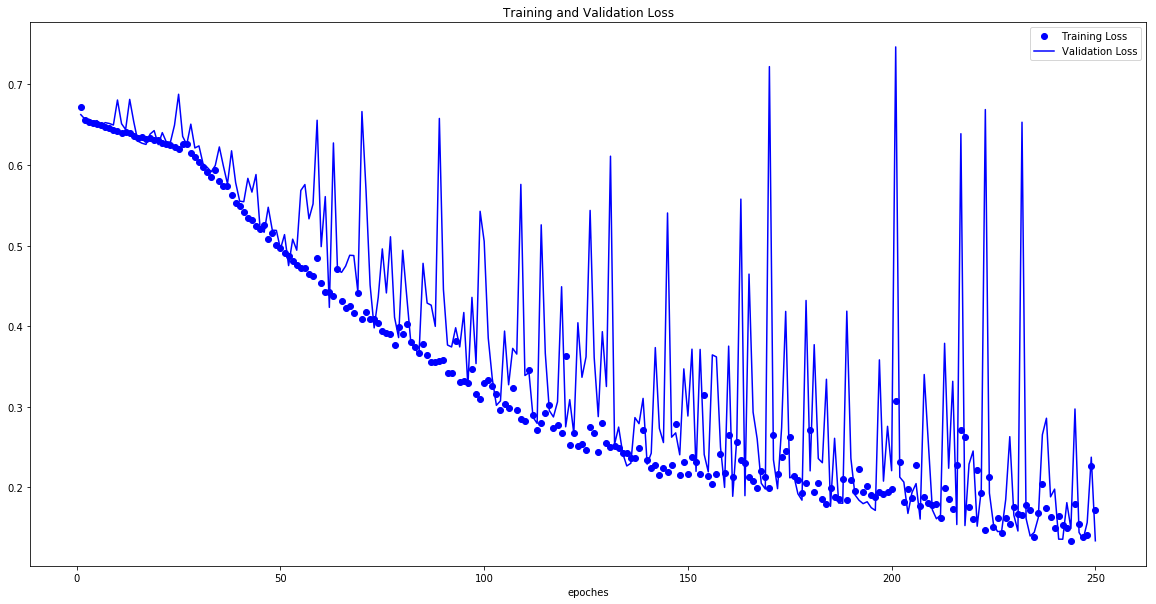

In [27]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(20, 10))
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('epoches')
plt.legend()

plt.figure(figsize=(20, 10))

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('epoches')
plt.legend()

plt.show()

The following cells format the test sequences, and calculate the test accuracy and loss based on the model trained above:

In [14]:
X_test_rnn = X_test.reshape(1072, 1000, 5)

In [15]:
X_test_rnn.shape

(1072, 1000, 5)

In [16]:
test_loss, test_accuracy = model.evaluate(X_test_rnn, y_test)

1072/1072 [==============================] - 6s 6ms/step


In [17]:
[test_loss, test_accuracy]

[0.15533507615327835, 0.9617537313432836]

The following cells import the one-hot encoded random sequences from the disk and calculate random sequences' accuracy/loss:

In [18]:
with open("/home/ubuntu/formatted/random_sequences/random_sequence_buffer.txt", "rb") as buff:
    random_seq_list = pickle.load(buff)
len(random_seq_list)

5000

In [19]:
random_X, random_y, _dummy_1, _dummy_2 = prepare_input(5000, 0, 1000, random_seq_list)
random_X, random_y, _dummy_1, _dummy_2 = to_np_array(random_X, random_y, _dummy_1, _dummy_2)
[random_X.shape, random_y.shape, _dummy_1.shape, _dummy_2.shape]

[(5000, 5000), (5000, 1), (0,), (0, 1)]

In [20]:
random_X_rnn = random_X.reshape(5000, 1000, 5)
random_loss, random_accuracy = model.evaluate(random_X_rnn, random_y)

5000/5000 [==============================] - 29s 6ms/step


In [21]:
[random_loss, random_accuracy]

[2.0275228759765627, 0.4986]


**Conclusion**:

- The following table details the final training, validation, testing, and random sequence's accuracy and loss:

Category        | Accuracy | Loss
----------------|----------|-------
Training        | 0.9461   | 0.1722
Validation      | 0.9659   | 0.1338
Testing         | 0.9618   | 0.1553
Random Sequence | 0.4986   | 2.0275

- Training, validation and testing align closely with each other, the random sequence differs vastly (actually the result of random sequence is even slightly worse than random guessing), proving that the model has no effect on random sequences.

- The fluctuation of validation accuracy is too volatile. I suspect the reason might due to the fact that only one motif was used.

- The next step is to validate if the trend is still true when using all three motifs.